In [11]:
import yfinance as yf
import pandas as pd

# List of tickers
tickers = [
    'XLK', 'XLF', 'XLY', 'XLV', 'XLC',
    'XLRE', 'XLB', 'XLP', 'XLU', 'XLI',
    'XLE', 'SPY'
]

atm_data = []

for ticker in tickers:
    stock = yf.Ticker(ticker)
    expirations = stock.options
    if not expirations:
        print(f"No expirations found for {ticker}")
        continue
    exp_date = expirations[0]  # soonest expiry

    # Get option chain for that date
    opt_chain = stock.option_chain(exp_date)
    calls = opt_chain.calls
    puts = opt_chain.puts

    # Get current price
    try:
        current_price = stock.history(period="1d")['Close'].iloc[-1]
    except Exception:
        current_price = None

    # Find ATM call (closest strike to current price)
    if current_price is not None and not calls.empty:
        calls['abs_diff'] = (calls['strike'] - current_price).abs()
        atm_call = calls.loc[calls['abs_diff'].idxmin()]
    else:
        atm_call = None

    # Find ATM put (closest strike to current price)
    if current_price is not None and not puts.empty:
        puts['abs_diff'] = (puts['strike'] - current_price).abs()
        atm_put = puts.loc[puts['abs_diff'].idxmin()]
    else:
        atm_put = None

    atm_data.append({
        'ticker': ticker,
        'exp_date': exp_date,
        'current_price': current_price,
        'atm_call_strike': atm_call['strike'] if atm_call is not None else None,
        'atm_call_bid': atm_call['bid'] if atm_call is not None else None,
        'atm_call_ask': atm_call['ask'] if atm_call is not None else None,
        'atm_call_iv': atm_call['impliedVolatility'] if atm_call is not None and 'impliedVolatility' in atm_call else None,
        'atm_put_strike': atm_put['strike'] if atm_put is not None else None,
        'atm_put_bid': atm_put['bid'] if atm_put is not None else None,
        'atm_put_ask': atm_put['ask'] if atm_put is not None else None,
        'atm_put_iv': atm_put['impliedVolatility'] if atm_put is not None and 'impliedVolatility' in atm_put else None,
    })

# Compile into DataFrame
atm_df = pd.DataFrame(atm_data)
atm_df

,ticker,exp_date,current_price,atm_call_strike,atm_call_bid,atm_call_ask,atm_call_iv,atm_put_strike,atm_put_bid,atm_put_ask,atm_put_iv
0,XLK,2025-08-15,268.250000,267.5,0.0,0.0,0.000010,267.5,0.0,0.0,0.015635
1,XLF,2025-08-15,52.705002,52.5,0.0,0.0,0.000010,52.5,0.0,0.0,0.015635
2,XLY,2025-08-15,229.044998,230.0,0.0,0.0,0.015635,230.0,0.0,0.0,0.000010
3,XLV,2025-08-15,132.580002,132.5,0.0,0.0,0.000010,132.5,0.0,0.0,0.003916
4,XLC,2025-08-15,111.169998,111.0,0.0,0.0,0.000010,110.0,0.0,0.0,0.031260
5,XLRE,2025-08-15,40.924999,41.0,0.0,0.0,0.007822,41.0,0.0,0.0,0.000010
6,XLB,2025-08-15,89.514999,89.5,0.0,0.0,0.000010,89.5,0.0,0.0,0.000987
7,XLP,2025-08-15,81.989998,82.0,0.0,0.0,0.000987,82.0,0.0,0.0,0.000010
8,XLU,2025-08-15,85.949997,86.0,0.0,0.0,0.003916,86.0,0.0,0.0,0.000010
9,XLI,2025-08-15,151.525497,152.0,0.0,0.0,0.015635,152.0,0.0,0.0,0.000010


In [12]:
sector_etf_map = {
    'realestate': 'XLRE',
    'consumer_cyclical': 'XLY',
    'basic_materials': 'XLB',
    'consumer_defensive': 'XLP',
    'technology': 'XLK',
    'communication_services': 'XLC',
    'financial_services': 'XLF',
    'utilities': 'XLU',
    'industrials': 'XLI',
    'energy': 'XLE',
    'healthcare': 'XLV'
}


In [13]:
import yfinance as yf
import pandas as pd

# Get SPY ETF info
spy = yf.Ticker("SPY")

# Pull sector weightings (if available)
sector_weights = spy.funds_data.sector_weightings
# Print sector breakdown
print(sector_weights)



{'realestate': 0.0199, 'consumer_cyclical': 0.10560001, 'basic_materials': 0.0161, 'consumer_defensive': 0.0523, 'technology': 0.3529, 'communication_services': 0.0986, 'financial_services': 0.1337, 'utilities': 0.024500001, 'industrials': 0.0784, 'energy': 0.03, 'healthcare': 0.088}


In [14]:
sorted_sectors = sorted(sector_weights.items(), key=lambda x: x[1], reverse=True)
top4 = sorted_sectors[:4]
total_top4 = sum(w for _, w in top4)
# Scale to 100%
scaled_top4 = {sector: weight / total_top4 * 100 for sector, weight in top4}
# Add SPY as 100%
scaled_top4['SPY'] = 100.0
# Get last close price for each sector ETF and SPY
etf_map = {
    'technology': 'XLK',
    'financial_services': 'XLF',
    'consumer_cyclical': 'XLY',
    'healthcare': 'XLV',
    'communication_services': 'XLC',
    'realestate': 'XLRE',
    'basic_materials': 'XLB',
    'consumer_defensive': 'XLP',
    'utilities': 'XLU',
    'industrials': 'XLI',
    'energy': 'XLE',
    'SPY': 'SPY'
}
data = []
for sector, weight in scaled_top4.items():
    ticker = etf_map.get(sector, None)
    if ticker:
        try:
            close = yf.Ticker(ticker).history(period="1d")['Close'].iloc[-1]
        except Exception:
            close = None
    else:
        close = None
    data.append({'sector': sector, 'ticker': ticker, 'weight': weight, 'last_close': close})
df = pd.DataFrame(data)

df['vector'] = df['weight'].values / df['last_close'].values
print(df)

                   sector ticker      weight  last_close    vector
0              technology    XLK   51.085697  268.250000  0.190441
1      financial_services    XLF   19.354371   52.705002  0.367221
2       consumer_cyclical    XLY   15.286625  229.044998  0.066741
3  communication_services    XLC   14.273306  111.169998  0.128392
4                     SPY    SPY  100.000000  644.159973  0.155241


In [15]:
import numpy as np

# Try a range of scaling factors and pick the one that minimizes the sum of fractional parts
scaling_factors = np.arange(1, 101, 0.1)
best_factor = None
best_score = float('inf')

for factor in scaling_factors:
    scaled = df['vector'].values * factor
    score = np.sum(np.abs(scaled - np.round(scaled)))  # sum of fractional parts
    if score < best_score:
        best_score = score
        best_factor = factor

print(f"Best scaling factor: {best_factor:.2f}")
print("Scaled values (rounded):")
print(np.round(df['weight'].values / df['last_close'].values * best_factor))
df['vector'] = np.round(df['weight'].values / df['last_close'].values * best_factor)

Best scaling factor: 46.30
Scaled values (rounded):
[ 9. 17.  3.  6.  7.]


In [16]:
import pandas as pd
import yfinance as yf

def is_third_friday(date_str):
    """Check if a date string (YYYY-MM-DD) is the 3rd Friday of the month."""
    date = pd.to_datetime(date_str)
    return date.weekday() == 4 and 15 <= date.day <= 21

def nearest_third_friday(min_days=30):
    """Return the nearest 3rd Friday more than min_days out from today."""
    today = pd.Timestamp.today().normalize()
    # Generate the next 12 months of Fridays
    for month_offset in range(0, 12):
        month = (today.month - 1 + month_offset) % 12 + 1
        year = today.year + ((today.month - 1 + month_offset) // 12)
        # Find all Fridays in this month
        for day in range(15, 22):
            try:
                d = pd.Timestamp(year=year, month=month, day=day)
                if d.weekday() == 4 and (d - today).days > min_days:
                    print(f"Nearest 3rd Friday >30d out: {d.strftime('%Y-%m-%d')}")
                    break
            except ValueError:
                continue
        else:
            continue
        break

def calc_straddle_cost(row):
    # Find the corresponding ATM row for this ticker
    atm_row = atm_df[atm_df['ticker'] == row['ticker']]
    if atm_row.empty:
        return None
    atm_row = atm_row.iloc[0]
    call_ask = atm_row['atm_call_ask']
    put_ask = atm_row['atm_put_ask']
    if pd.isna(call_ask) or pd.isna(put_ask):
        return None
    # Option contracts are for 100 shares
    straddle_cost = (call_ask + put_ask) * 100
    return straddle_cost * row['vector']

def calc_atm_iv(row):
    atm_row = atm_df[atm_df['ticker'] == row['ticker']]
    if atm_row.empty:
        return None
    atm_row = atm_row.iloc[0]
    # Use the average of call and put IV if both are available, else use whichever is present
    call_iv = atm_row['atm_call_iv']
    put_iv = atm_row['atm_put_iv']
    if pd.notna(call_iv) and pd.notna(put_iv):
        avg_iv = (call_iv + put_iv) / 2
    elif pd.notna(call_iv):
        avg_iv = call_iv
    elif pd.notna(put_iv):
        avg_iv = put_iv
    else:
        return None
    return avg_iv * row['vector']



In [ ]:
df['atm_straddle_cost'] = df.apply(calc_straddle_cost, axis=1)
# print(df[['ticker', 'vector', 'atm_straddle_cost']])
# print(f"Total scaled straddle cost: {df['atm_straddle_cost'].sum():.2f}")
spy_cost = df.loc[df['ticker'] == 'SPY', 'atm_straddle_cost'].values[0]
sector_sum = df.loc[df['ticker'] != 'SPY', 'atm_straddle_cost'].sum()
dispersion = sector_sum - spy_cost

df['atm_iv_scaled'] = df.apply(calc_atm_iv, axis=1)
spy_iv = df.loc[df['ticker'] == 'SPY', 'atm_iv_scaled'].values[0] / df.loc[df['ticker'] == 'SPY', 'vector'].values[0]
sector_iv_sum = df.loc[df['ticker'] != 'SPY', 'atm_iv_scaled'].sum() / df.loc[df['ticker'] != 'SPY', 'vector'].sum()
dispersion_iv = sector_iv_sum - spy_iv

## Print costs ##
print(f"Sum of sector scaled straddle costs (ex SPY): {sector_sum:.2f}")
print(f"SPY scaled straddle cost: {spy_cost:.2f}")
print(f"Dispersion (sector sum minus SPY): {dispersion:.2f}")
## Print iv ##
print(df[['ticker', 'vector', 'atm_iv_scaled', 'atm_straddle_cost']])
print(f"Sum of sector scaled IVs (ex SPY): {sector_iv_sum:.4f}")
print(f"SPY scaled IV: {spy_iv:.4f}")
print(f"IV Dispersion (sector sum minus SPY): {dispersion_iv:.4f}")

  ticker  vector  atm_iv_scaled  atm_straddle_cost
0    XLK     9.0       0.070402                0.0
1    XLF    17.0       0.132981                0.0
2    XLY     3.0       0.023467                0.0
3    XLC     6.0       0.093809                0.0
4    SPY     7.0       0.006906                0.0
Sum of sector scaled IVs (ex SPY): 0.3207
SPY scaled IV: 0.0069
IV Dispersion (sector sum minus SPY): 0.3138


In [19]:
import os
import json
from datetime import datetime

# Prepare output dictionary
output = {
    'ticker': df['ticker'].tolist(),
    'vector': df['vector'].tolist(),
    'spot': df['last_close'].tolist(),
    'straddle_price': df['atm_straddle_cost'].tolist(),
    'dispersion_spread_cost': float(dispersion),
    'iv': df['atm_iv_scaled'].tolist(),
    'iv_spread': float(dispersion_iv)
}

# Current date/time
now_str = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
filename = '../data/results/dispersion_output_indexed.json'

# Ensure folder exists
os.makedirs(os.path.dirname(filename), exist_ok=True)

# Load existing data
try:
    with open(filename, 'r', encoding='utf-8') as f:
        all_outputs = json.load(f)
except (FileNotFoundError, json.JSONDecodeError):
    all_outputs = {}

# Add new entry
all_outputs[now_str] = output

# Save with Unix line endings
with open(filename, 'w', encoding='utf-8', newline='\n') as f:
    json.dump(all_outputs, f, indent=2)

print(f"Saved results to {filename} under key {now_str}")


Saved results to ../data/results/dispersion_output_indexed.json under key 2025-08-14 21:52:29


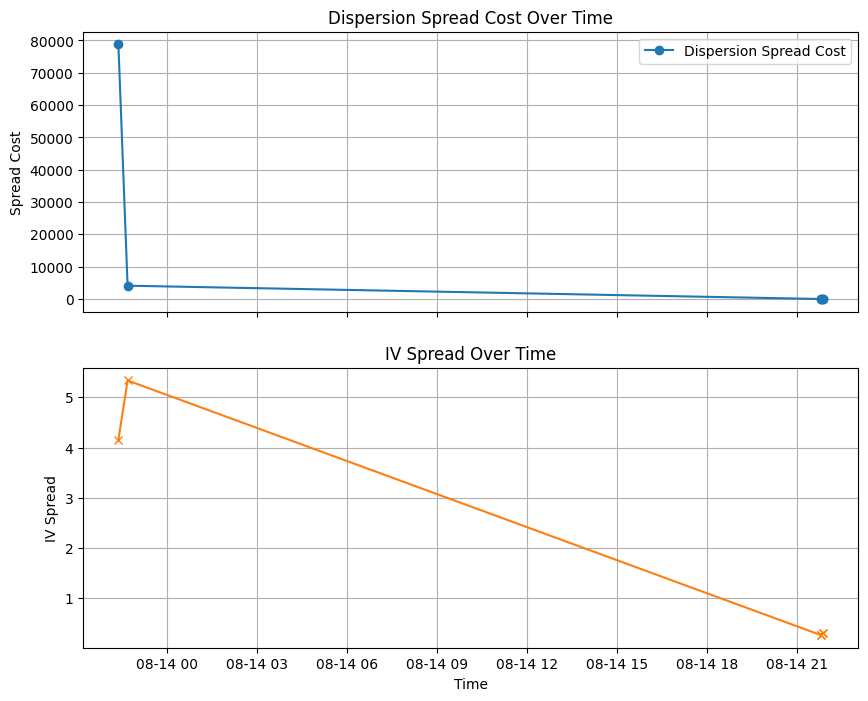

In [21]:
import json
import matplotlib.pyplot as plt
from datetime import datetime

# Load results
with open('../data/results/dispersion_output_indexed.json', 'r', encoding='utf-8') as f:
    results = json.load(f)

# Extract time series
times = []
spread_costs = []
iv_spreads = []

for ts, entry in results.items():
    times.append(datetime.strptime(ts, '%Y-%m-%d %H:%M:%S'))
    spread_costs.append(entry['dispersion_spread_cost'])
    iv_spreads.append(entry['iv_spread'])

# Plot on separate subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,8), sharex=True)

ax1.plot(times, spread_costs, label='Dispersion Spread Cost', marker='o', color='tab:blue')
ax1.set_ylabel('Spread Cost')
ax1.set_title('Dispersion Spread Cost Over Time')
ax1.grid(True)
ax1.legend()

ax2.plot(times, iv_spreads, label='IV Spread', marker='x', color='tab:orange')
ax2.set_xlabel('Time')
ax2.set_ylabel('IV Spread')
ax2.set_title('IV Spread Over Time')
ax2.grid(True)